# Ultra fast lowess
Hi, welcome to the Ultra Fast Lowess tutorial

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import statsmodels.api as sm 
lowess = sm.nonparametric.lowess
import dask

In [2]:
# client.close()

In [3]:
from dask.distributed import Client
# Optimal client set-up for ARE
client = Client(memory_limit=None, threads_per_worker=1, n_workers=12)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 12
Total threads: 12,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39483,Workers: 12
Dashboard: /proxy/8787/status,Total threads: 12
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:36333,Total threads: 1
Dashboard: /proxy/36319/status,Memory: 0 B
Nanny: tcp://127.0.0.1:43755,


In [4]:
# Create sample data
latitudes = np.linspace(-90, 90, 1000)  # Sample latitudes
longitudes = np.linspace(-180, 180, 100)  # Sample longitudes
times = pd.date_range("2024-01-01", periods=500, freq="D")  # 100 time steps

# Create random data for the DataArray
data = np.random.rand(len(times), len(latitudes), len(longitudes))

# Create the xarray DataArray
data_xarray = xr.DataArray(
    data,
    dims=("time", "latitude", "longitude"),
    coords={
        "time": times,
        "latitude": latitudes,
        "longitude": longitudes
    }
)#.chunk({'time':-1, 'latitude':250})

data_xarray.name = 'tas'

In [5]:
data_xarray = data_xarray.chunk({'time':-1,
                                'latitude':25,
                                'longitude': 25})

In [6]:
# Usally the chunk size recommended is around 100mb. However, that is just for 
# standard calculations. Lowess is heavy in time - so I am going to make the 
# chunks tiny and then scale the number of workers up massivly
data_xarray

<xarray.DataArray 'tas' (time: 500, latitude: 1000, longitude: 100)> Size: 400MB
dask.array<xarray-<this-array>, shape=(500, 1000, 100), dtype=float64, chunksize=(500, 25, 25), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 4kB 2024-01-01 2024-01-02 ... 2025-05-14
  * latitude   (latitude) float64 8kB -90.0 -89.82 -89.64 ... 89.64 89.82 90.0
  * longitude  (longitude) float64 800B -180.0 -176.4 -172.7 ... 176.4 180.0

In [7]:
def apply_lowess(arr: np.ndarray) -> np.ndarray:
    """
    Apply LOWESS (Locally Weighted Scatterplot Smoothing) to a 1D array.

    Parameters:
    arr (numpy.ndarray): Input array containing the data to smooth. 
                         Can contain NaN values.

    Returns:
    numpy.ndarray: Smoothed array with the same shape as the input.
                   If all values in `arr` are NaN, the input array is returned unchanged.
    """
    # Check if the entire array consists of NaN values
    if all(np.isnan(arr)): return arr

    # Create an array of indices for the x-axis
    x = np.arange(arr.shape[0])
    
    # Apply the LOWESS smoothing function
    # `lowess` uses x as the independent variable and arr as the dependent variable
    yhat = lowess(arr, x, return_sorted=False)
    
    return yhat

In [8]:
lowess_ds = xr.apply_ufunc(
    apply_lowess, # The function to apply
    data_xarray, # The data to apply the function to
    input_core_dims=[['time']], # What dimension to apply the funcion to
    output_core_dims=[['time']], # What dimension to be returned
    vectorize=True, # Needed to apply along time
    dask='parallelized', # We are using dask
    output_dtypes=[float] # Sometimes needed sometimes not
)

In [9]:
lowess_ds

<xarray.DataArray 'tas' (latitude: 1000, longitude: 100, time: 500)> Size: 400MB
dask.array<transpose, shape=(1000, 100, 500), dtype=float64, chunksize=(25, 25, 500), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 4kB 2024-01-01 2024-01-02 ... 2025-05-14
  * latitude   (latitude) float64 8kB -90.0 -89.82 -89.64 ... 89.64 89.82 90.0
  * longitude  (longitude) float64 800B -180.0 -176.4 -172.7 ... 176.4 180.0

In [10]:
# This scales the number of workers.
# Only scale the number of workers to at most the number of cpus
client.cluster.scale(50)

In [11]:
%%time
# Run time without cluster scaling: 2min 47s
# Run time with cluster scaling: 58.2
lowess_ds = lowess_ds.compute()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 381.51 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 24.3 s, sys: 5.95 s, total: 30.3 s
Wall time: 1min 2s


Matplotlib created a temporary cache directory at /jobfs/129457517.gadi-pbs/matplotlib-beqn393_ because the default path (/home/563/ab2313/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


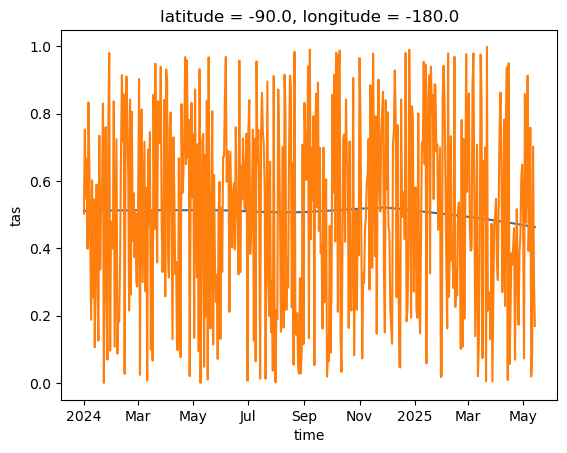

In [12]:
lowess_ds.isel(latitude=0, longitude=0).plot()
data_xarray.isel(latitude=0, longitude=0).plot()

# Hypothesis Tests

In [13]:
data_xarray

<xarray.DataArray 'tas' (time: 500, latitude: 1000, longitude: 100)> Size: 400MB
dask.array<xarray-<this-array>, shape=(500, 1000, 100), dtype=float64, chunksize=(500, 25, 25), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 4kB 2024-01-01 2024-01-02 ... 2025-05-14
  * latitude   (latitude) float64 8kB -90.0 -89.82 -89.64 ... 89.64 89.82 90.0
  * longitude  (longitude) float64 800B -180.0 -176.4 -172.7 ... 176.4 180.0

In [14]:
# The size of the window to analys the KS test over
window = 20

In [15]:
data_ds = data_xarray

In [16]:
# Creting new datasets that has windown dimnsion for the rolling calculation
data_ds_window = (data_ds
                  .rolling(time=window, center=True, min_periods=window)
                  .construct('window_dim')
                  .persist()) 

base_period_window_ds = (data_ds.isel(time=slice(0, 50))
                         .rename({'time':'window_dim'})
                         .persist())

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 382.00 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 381.49 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [17]:
data_ds_window

<xarray.DataArray 'tas' (time: 500, latitude: 1000, longitude: 100,
                         window_dim: 20)> Size: 8GB
dask.array<sliding_window_view, shape=(500, 1000, 100, 20), dtype=float64, chunksize=(499, 25, 25, 20), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 4kB 2024-01-01 2024-01-02 ... 2025-05-14
  * latitude   (latitude) float64 8kB -90.0 -89.82 -89.64 ... 89.64 89.82 90.0
  * longitude  (longitude) float64 800B -180.0 -176.4 -172.7 ... 176.4 180.0
Dimensions without coordinates: window_dim

In [18]:
base_period_window_ds

<xarray.DataArray 'tas' (window_dim: 50, latitude: 1000, longitude: 100)> Size: 40MB
dask.array<getitem, shape=(50, 1000, 100), dtype=float64, chunksize=(50, 25, 25), chunktype=numpy.ndarray>
Coordinates:
  * window_dim  (window_dim) datetime64[ns] 400B 2024-01-01 ... 2024-02-19
  * latitude    (latitude) float64 8kB -90.0 -89.82 -89.64 ... 89.64 89.82 90.0
  * longitude   (longitude) float64 800B -180.0 -176.4 -172.7 ... 176.4 180.0

In [19]:
from scipy.stats import ks_2samp

In [20]:
def remove_nans(arr1, arr2):
    """
    Remove NaN values from two input arrays.

    Parameters:
    arr1 (numpy array): The first input array.
    arr2 (numpy array): The second input array.

    Returns:
    tuple: Two arrays with NaN values removed.

    Notes:
    This function uses NumPy's isfinite function to identify and remove NaN values.
    """
    # Remove NaN values using NumPy's isfinite function
    arr1 = arr1[np.isfinite(arr1)]  # Remove NaN values from arr1
    arr2 = arr2[np.isfinite(arr2)]  # Remove NaN values from arr2

    return arr1, arr2  # Return the updated arrays

def return_ks_2samp(arr1, arr2):
    """
    Calculate the p-value for a given statistical test for two arrays.

    Parameters:
    arr1 (numpy array): The first input array.
    arr2 (numpy array): The second input array.

    Returns:
    float: The p-value of the specified statistical test.

    Notes:
    If either array contains only NaN values, the function returns NaN.
    """
    # Check if all values are nan
    if np.all(np.isnan(arr1)) or np.all(np.isnan(arr2)): return np.nan
    arr1, ar2 = remove_nans(arr1, arr2)

    return ks_2samp(arr1, arr2).pvalue

In [21]:
ks_ds = xr.apply_ufunc(
        return_ks_2samp,
        data_ds_window,
        base_period_window_ds,
        input_core_dims=[['window_dim'], ['window_dim']],
        exclude_dims={'window_dim'},
        vectorize=True,
        dask='parallelized',
        output_dtypes=[float]
    )

In [22]:
ks_ds

<xarray.DataArray 'tas' (time: 500, latitude: 1000, longitude: 100)> Size: 400MB
dask.array<transpose, shape=(500, 1000, 100), dtype=float64, chunksize=(499, 25, 25), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 4kB 2024-01-01 2024-01-02 ... 2025-05-14
  * latitude   (latitude) float64 8kB -90.0 -89.82 -89.64 ... 89.64 89.82 90.0
  * longitude  (longitude) float64 800B -180.0 -176.4 -172.7 ... 176.4 180.0

In [23]:
# This scales the number of workers.
# Only scale the number of workers to at most the number of cpus
client.cluster.scale(50)

In [24]:
%%time
# 5min 23s seconds with 50 workers
ks_ds = ks_ds.compute()

CPU times: user 2min 12s, sys: 25 s, total: 2min 37s
Wall time: 5min 23s
